In [ ]:
%matplotlib inline

# Introduction to Deep Learning with Keras and TensorFlow


To help you understand the fundamentals of deep learning, this demo will walk through the basic steps of building two toy models for classifying handwritten numbers with accuracies surpassing 95%. The first model will be a basic fully-connected neural network, and the second model will be a deeper network that introduces the concepts of convolution and pooling.

## The Task for the AI

Our goal is to construct and train an artificial neural network on thousands of images of handwritten digits so that it may successfully identify others when presented. The data that will be incorporated is the MNIST database which contains 60,000 images for training and 10,000 test images. We will use the Keras Python API with TensorFlow as the backend.

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/mnist.png?raw=1" >

## Prerequisite Python Modules

First, some software needs to be loaded into the Python environment.

In [ ]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers

from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.models import Sequential  # Model type to be used

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools

## Loading Training Data

The MNIST dataset is conveniently bundled within Keras, and we can easily analyze some of its features in Python.

In [ ]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


Using matplotlib, we can plot some sample images from the training set directly into this Jupyter Notebook.

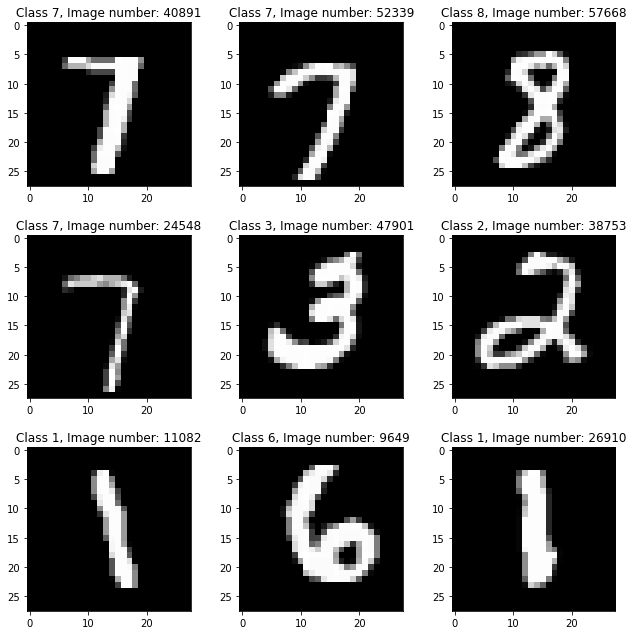

In [ ]:
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}, Image number: {}".format(y_train[num],num))
    
plt.tight_layout()

Let's examine a single digit a little closer, and print out the array representing the last digit.

In [ ]:
# just a little function for pretty printing a matrix
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# now print!        
matprint(X_train[22660])

0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  
0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  
0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  
0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  
0  0  0  0  0    0    0    0    0    0    0    0  147  219   25    0    0    0    0    0    0    0    0  0  0  0  0  0  
0  0  0  0  0    0    0    0    0    0    0   65  250  254   46    0    0    0    0    0    0   23    6  0  0  0  0  0  
0  0  0  0  0    0    0    0    0    0    4  225  254  176    0    0    0    0    0    0  105  231   41  0  0  0  0  0  
0  0  0  0  0    0    0    0    0    0   54  250  254   66    0    0    0    0    0    0  151  254  194  0  0  0  0  0  
0  0  0  0  0    0    0    0    

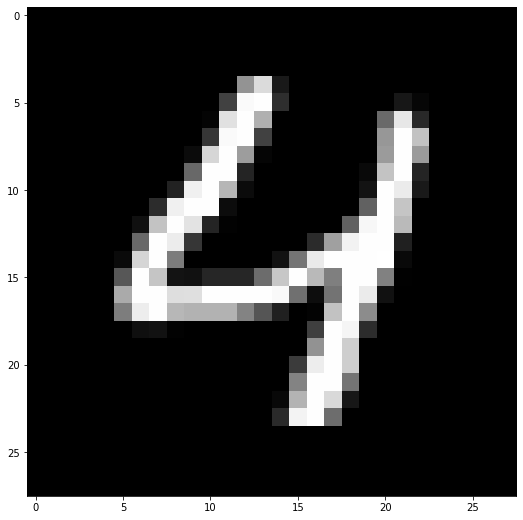

In [ ]:
plt.imshow(X_train[22660], cmap='gray', interpolation='none')

Each pixel is an 8-bit integer from 0-255. 0 is full black, while 255 is full white. This what we call a single-channel pixel. It's called monochrome.

*Fun-fact! Your computer screen has three channels for each pixel: red, green, blue. Each of these channels also likely takes an 8-bit integer. 3 channels -- 24 bits total -- 16,777,216 possible colors!*

## Formatting the input data layer

Instead of a 28 x 28 matrix, we build our network to accept a 784-length vector.

Each image needs to be then reshaped (or flattened) into a vector. We'll also normalize the inputs to be in the range [0-1] rather than [0-255]. Normalizing inputs is generally recommended, so that any additional dimensions (for other network architectures) are of the same scale.

<img src='https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/flatten.png?raw=1' >

In [ ]:
X_train = X_train.reshape(60000, 784) # reshape 60,000 28 x 28 = 784 matrices into 60,000 784-length vectors.
X_test = X_test.reshape(10000, 784)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.

X_train = X_train.astype('float32')   # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255   #0-1                     # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


In [ ]:
y_train[22660]

4

We then modify our classes (unique digits) to be in the one-hot format, i.e.

```

> Indented block

> Indented block

 0  1  2  3  4  5  7  8  9 
[0, 0, 0, 0, 0, 0, 1, 0, 0]

0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.
```

If the final output of our network is very close to one of these classes, then it is most likely that class. For example, if the final output is:

```
[0, 0.94, 0, 0, 0, 0, 0.06, 0, 0]
```
then it is most probable that the image is that of the digit `1`.

In [ ]:
nb_classes = 10 # number of unique digits

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [ ]:
print(y_train[22660],Y_train[22660])

4 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


# Building a 3-layer fully connected network (FCN)

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/figure.png?raw=1" />

In [ ]:
# The Sequential model is a linear stack of layers and is very common.

model = Sequential()

## The first hidden layer

In [ ]:
# The first hidden layer is a set of 512 nodes (artificial neurons).
# Each node will receive an element from each input vector and apply some weight and bias to it.

model.add(Dense(512, input_shape=(784,))) #(784,) is not a typo -- that represents a 784 length vector!

In [ ]:
# An "activation" is a non-linear function applied to the output of the layer above.
# It checks the new value of the node, and decides whether that artifical neuron has fired.
# The Rectified Linear Unit (ReLU) converts all negative inputs to nodes in the next layer to be zero.
# Those inputs are then not considered to be fired.
# Positive values of a node are unchanged.

model.add(Activation('relu'))

$$f(x) = max (0,x)$$
<img src = 'relu.jpg' >

In [ ]:
# Dropout zeroes a selection of random outputs (i.e., disables their activation)
# Dropout helps protect the model from memorizing or "overfitting" the training data.
model.add(Dropout(0.2))

## Adding the second hidden layer

In [ ]:
# The second hidden layer appears identical to our first layer.
# However, instead of each of the 512-node receiving 784-inputs from the input image data,
# they receive 512 inputs from the output of the first 512-node layer.

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

## The Final Output Layer

In [ ]:
# The final layer of 10 neurons in fully-connected to the previous 512-node layer.
# The final layer of a FCN should be equal to the number of desired classes (10 in this case).
model.add(Dense(10))

In [ ]:
# The "softmax" activation represents a probability distribution over K different possible outcomes.
# Its values are all non-negative and sum to 1.

model.add(Activation('softmax'))

In [ ]:
# Summarize the built model

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                5

## Compiling the model

Keras is built on top of Theano and TensorFlow. Both packages allow you to define a *computation graph* in Python, which then compiles and runs efficiently on the CPU or GPU without the overhead of the Python interpreter.

When compiing a model, Keras asks you to specify your **loss function** and your **optimizer**. The loss function we'll use here is called *categorical cross-entropy*, and is a loss function well-suited to comparing two probability distributions.

Our predictions are probability distributions across the ten different digits (e.g. "we're 80% confident this image is a 3, 10% sure it's an 8, 5% it's a 2, etc."), and the target is a probability distribution with 100% for the correct category, and 0 for everything else. The cross-entropy is a measure of how different your predicted distribution is from the target distribution. [More detail at Wikipedia](https://en.wikipedia.org/wiki/Cross_entropy)

The optimizer helps determine how quickly the model learns through **gradient descent**. The rate at which descends a gradient is called the **learning rate**.

<img src = "gradient_descent.png" >

<img src = "learning_rate.png" >

So are smaller learning rates better? Not quite! It's important for an optimizer not to get stuck in local minima while neglecting the global minimum of the loss function. Sometimes that means trying a larger learning rate to jump out of a local minimum.

<img src = 'complicated_loss_function.png' >

In [ ]:
# Let's use the Adam optimizer for learning
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model!
This is the fun part! 

The batch size determines over how much data per step is used to compute the loss function, gradients, and back propagation. Large batch sizes allow the network to complete it's training faster; however, there are other factors beyond training speed to consider.

Too large of a batch size smoothes the local minima of the loss function, causing the optimizer to settle in one because it thinks it found the global minimum.

Too small of a batch size creates a very noisy loss function, and the optimizer may never find the global minimum.

So a good batch size may take some trial and error to find!

In [ ]:
model.fit(X_train, Y_train, #60.000
          batch_size=128, epochs=10,
          verbose=1)

Epoch 1/10
469/469 [==============================] - 9s 17ms/step - loss: 0.2503 - accuracy: 0.9245
Epoch 2/10
469/469 [==============================] - 8s 16ms/step - loss: 0.1010 - accuracy: 0.9690
Epoch 3/10
469/469 [==============================] - 7s 16ms/step - loss: 0.0721 - accuracy: 0.9774
Epoch 4/10
469/469 [==============================] - 8s 16ms/step - loss: 0.0568 - accuracy: 0.9817
Epoch 5/10
469/469 [==============================] - 7s 16ms/step - loss: 0.0486 - accuracy: 0.9843
Epoch 6/10
469/469 [==============================] - 8s 16ms/step - loss: 0.0381 - accuracy: 0.9876
Epoch 7/10
469/469 [==============================] - 8s 17ms/step - loss: 0.0343 - accuracy: 0.9882
Epoch 8/10
469/469 [==============================] - 7s 16ms/step - loss: 0.0302 - accuracy: 0.9901
Epoch 9/10
469/469 [==============================] - 8s 17ms/step - loss: 0.0295 - accuracy: 0.9898
Epoch 10/10
469/469 [==============================] - 8s 18ms/step - loss: 0.0262 - accura

The two numbers, in order, represent the value of the loss function of the network on the training set, and the overall accuracy of the network on the training data. But how does it do on data it did not train on?

## Evaluate Model's Accuracy on Test Data

In [ ]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0633 - accuracy: 0.9833
Test score: 0.06332247704267502
Test accuracy: 0.983299970626831


### Inspecting the output

It's always a good idea to inspect the output and make sure everything looks sane. Here we'll look at some examples it gets right, and some examples it gets wrong.

In [ ]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = np.argmax(model.predict(X_test),axis=1)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]

incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

In [ ]:
incorrect_indices[0]

0

In [ ]:
np.argmax(model.predict(X_test),axis=1).shape

(10000,)

Real value is 9
Predicted value is 1


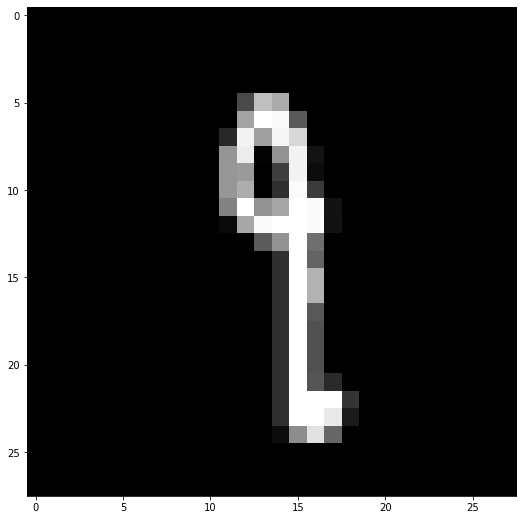

In [ ]:
print('Real value is {}'.format(y_test[incorrect_indices[100]]))
print('Predicted value is {}'.format(predicted_classes[incorrect_indices[100]]))
plt.imshow(X_test[incorrect_indices[100]].reshape(28,28), cmap='gray', interpolation='none')

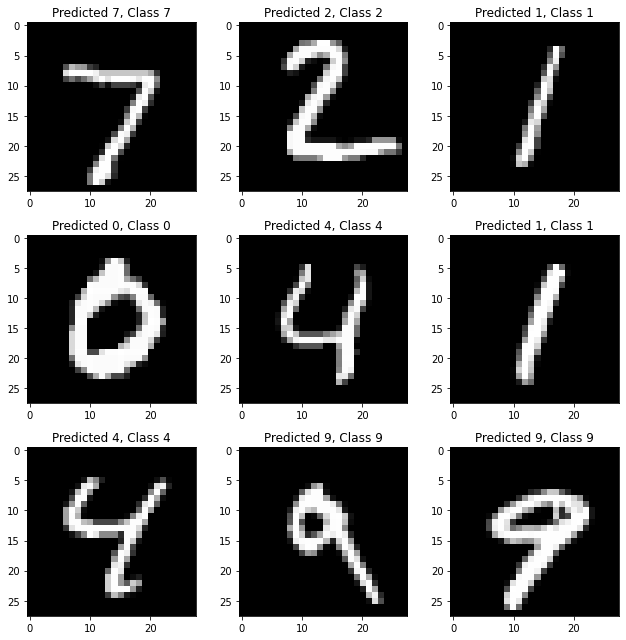

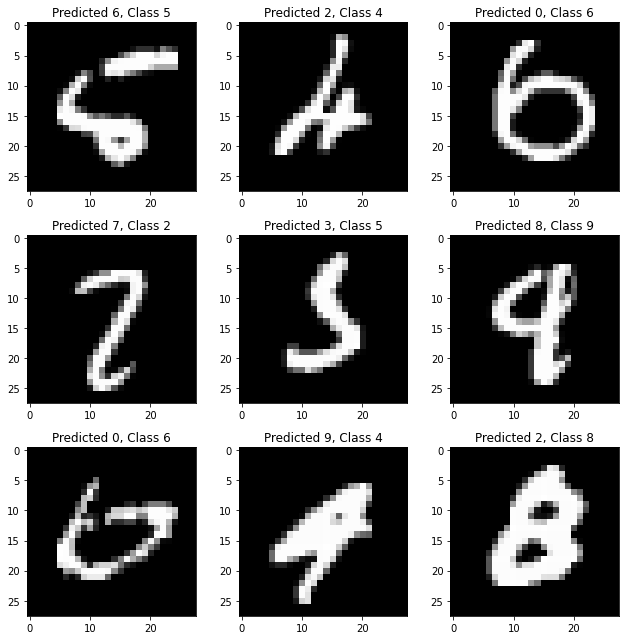

In [ ]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    
plt.tight_layout()
    
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    
plt.tight_layout()

#Upload your own image

draw the handwritten digit in any graphics editor and check how well the neural network can recognize it ysing the code below:

In [ ]:
from google.colab import files

files.upload()

Saving Снимок экрана 2022-04-20 в 19.43.15.png to Снимок экрана 2022-04-20 в 19.43.15.png


{'Снимок экрана 2022-04-20 в 19.43.15.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x13\x00\x00\x02\x1a\x08\x06\x00\x00\x00\x9a\xac\xcf\xec\x00\x00\x18\x80iCCPICC Profile\x00\x00X\x85\x95y\x07T\x14M\xb3v\xcfFvY\x96\x9csN\x92s\xce9\xe7(\xb0\xe4\x9c3*Q$\xa8\x04\x01E@\x05\x15\x04\x15L\x04\x11\x15\x11D\x14\x11T\xc0\x80HP$\xa9\xa0\x82  w\x08\xfa\xbe\x9f\xdf\x7f\xfe{n\x9f\xd33\xcfVWWUWuOM\xed\x00\xc0:B\n\x0f\x0fFP\x01\x10\x12\x1a\x1dim\xa0\xcd\xe5\xe8\xe4\xcc\x85\x9d\x02\x10\xa0\x01\x0c@\x1a(\x91\xbc\xa2\xc2\xb5,-M\x01\xdc~\xdf\xff\xb3-\x0f\xc1\xdcp{.\xb6%\xeb\xbf\xc7\xff\xbf\x8d\xc6\xdb\'\xca\x0b\x00\xc8\x15\xc6\x9e\xdeQ^!0n\x07\x00U\xee\x15\x1e\x19\r\x00f\x8b\xce\x1b\x17\x1d\xbe\x85S`L\x17\t\x1b\x08\xe3\xa2-\xec\xb7\x83/la\xcf\x1d\xdc\xb6\xcdck\xad\x03\xe3~\x00\xc8\x08$R\xa4\x1f\x00\xc4\x11\x98\xce\x15\xeb\xe5\x07\xcb!\xae\xc3c4\xa1\xde\x01\xa1\x00\xd0\xc3+\xc7\xa8{\xf9\x93\xbc\x01`\xb5\x84y\xf6\x84\x84\x84m\xe1}0\x16\x82\xf9\xc3a|\x0e\xc6\x8a\x9e\xff\x92\xe9\xf7\x1f\xf2=\xff\xc8

In [ ]:
from tensorflow.keras.preprocessing import image
img_path = 'Снимок экрана 2022-04-20 в 19.43.15.png' # change the image name according to the name of uploaded file
img = image.load_img(img_path, target_size=(28, 28), color_mode = "grayscale")

## Display your image

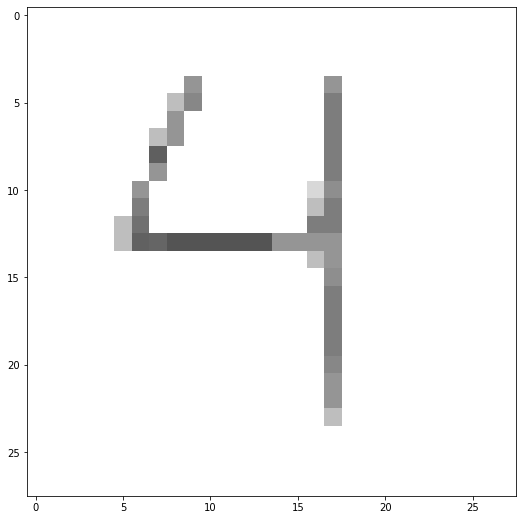

In [ ]:
plt.imshow(img.convert('RGBA'))
plt.show()

In [ ]:
# Convert the image in the format computer can work
x = image.img_to_array(img)
x = x.reshape(1, 784)
x = 255 - x
x /= 255

In [ ]:
# Convert the image in the format computer can work
x = image.img_to_array(img)
x = x.reshape(1, 28,28,1)
#x = 255 - x
x /= 255

In [ ]:
prediction = np.argmax(model.predict(x))
print("Your digit is {}".format(prediction))

Your digit is 4


In [ ]:
prediction = np.argmax(model.predict(x))
print("Your digit is {}".format(prediction))

Your digit is 5


In [ ]:
model.predict(x)

array([[0.00099361, 0.01094068, 0.00110069, 0.00090222, 0.8234358 ,
        0.0862354 , 0.00547703, 0.01750986, 0.03189082, 0.02151398]],
      dtype=float32)